In [73]:
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import f1_score

In [74]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '3,4,5'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [75]:
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 3


In [76]:
fight_datapath = './indoor/'
# fight_train_video_names = os.listdir(fight_datapath+'Training'+'/01.원천데이터')
# fight_val_video_names = os.listdir(fight_datapath+'Validation'+'/01.원천데이터')
fight_train_video_names = pd.read_csv('./fight_train_video_names_list.csv')['names'].to_list()
fight_val_video_names = pd.read_csv('./fight_val_video_names_list.csv')['names'].to_list()
fight_train_xml_names = os.listdir(fight_datapath+'Training'+'/02.라벨링데이터')
fight_val_xml_names = os.listdir(fight_datapath+'Validation'+'/02.라벨링데이터')

normal_datapath = './indoor_normal/'
normal_train_video_names = os.listdir(normal_datapath+'Training'+'/01.원천데이터')
normal_val_video_names = os.listdir(normal_datapath+'Validation'+'/01.원천데이터')

In [77]:
fight_train_video_names = list(map(lambda x:'./indoor/Training/01.원천데이터/'+x, fight_train_video_names))
fight_val_video_names = list(map(lambda x:'./indoor/Validation/01.원천데이터/'+x, fight_val_video_names))
normal_train_video_names = list(map(lambda x:'./indoor_normal/Training/01.원천데이터/'+x, normal_train_video_names))
normal_val_video_names = list(map(lambda x:'./indoor_normal/Validation/01.원천데이터/'+x, normal_val_video_names))

In [78]:
# fight_train_video_namesR = []
# fight_val_video_namesR = []

# for xml in fight_train_xml_names:
#     if xml.endswith('.xml'):
#         annot = pd.read_xml(fight_datapath+'Training'+'/02.라벨링데이터/'+xml)
#         track = pd.read_xml(fight_datapath+'Training'+'/02.라벨링데이터/'+xml, xpath='.//track')
#         if track['label'][0] == 'fight_start':
#             if annot['source'][1] in fight_train_video_names:
#                 fight_train_video_namesR.append(annot['source'][1])
#             else:
#                 print('Not exist file :', annot['source'][1])

# for xml in fight_val_xml_names:
#     if xml.endswith('.xml'):
#         annot = pd.read_xml(fight_datapath+'Validation'+'/02.라벨링데이터/'+xml)
#         track = pd.read_xml(fight_datapath+'Validation'+'/02.라벨링데이터/'+xml, xpath='.//track')
#         if track['label'][0] == 'fight_start':
#             if annot['source'][1] in fight_val_video_names:
#                 fight_val_video_namesR.append(annot['source'][1])
#             else:
#                 print('Not exist file :', annot['source'][1])

In [79]:
# fight_train_video_namesR

In [80]:
# pd.DataFrame(fight_train_video_namesR).to_csv('./fight_train_video_names_list.csv', header=['names'])

In [81]:
# pd.DataFrame(fight_val_video_namesR).to_csv('./fight_val_video_names_list.csv', header=['names'])

In [82]:
fight_train_video_names

['./indoor/Training/01.원천데이터/C_3_13_12_BU_SMB_09-01_15-38-42_CB_RGB_DF2_F2.mp4',
 './indoor/Training/01.원천데이터/C_3_13_10_BU_SMB_09-01_15-34-04_CC_RGB_DF2_F2.mp4',
 './indoor/Training/01.원천데이터/C_3_13_24_BU_SMB_09-01_15-01-52_CD_RGB_DF2_F3.mp4',
 './indoor/Training/01.원천데이터/C_3_13_14_BU_SYB_09-28_15-48-28_CD_RGB_DF2_M2.mp4',
 './indoor/Training/01.원천데이터/C_3_13_18_BU_DYB_10-17_14-05-13_CC_RGB_DF2_F3.mp4',
 './indoor/Training/01.원천데이터/C_3_13_3_BU_SMA_08-30_14-58-01_CA_RGB_DF2_F1.mp4',
 './indoor/Training/01.원천데이터/C_3_13_9_BU_SYB_09-28_15-41-01_CB_RGB_DF2_F2.mp4',
 './indoor/Training/01.원천데이터/C_3_13_4_BU_SMC_08-07_13-55-45_CA_RGB_DF2_M1.mp4',
 './indoor/Training/01.원천데이터/C_3_13_2_BU_SMB_08-30_17-06-31_CC_RGB_DF2_F1.mp4',
 './indoor/Training/01.원천데이터/C_3_13_21_BU_SYB_10-04_15-12-19_CC_RGB_DF2_F3.mp4',
 './indoor/Training/01.원천데이터/C_3_13_8_BU_DYB_10-17_11-29-21_CC_RGB_DF2_M2.mp4',
 './indoor/Training/01.원천데이터/C_3_13_3_BU_SMC_08-07_13-54-17_CB_RGB_DF2_F1.mp4',
 './indoor/Training/01.원천데이터/C_3_1

In [83]:
fight_val_video_names

['./indoor/Validation/01.원천데이터/C_3_13_32_BU_DYA_08-23_17-10-37_CE_RGB_DF2_F2_M2.mp4',
 './indoor/Validation/01.원천데이터/C_3_13_33_BU_SMB_09-05_14-12-32_CB_RGB_DF2_F4.mp4',
 './indoor/Validation/01.원천데이터/C_3_13_32_BU_SYA_09-14_14-06-36_CD_RGB_DF2_F4.mp4',
 './indoor/Validation/01.원천데이터/C_3_13_34_BU_SMB_09-05_14-18-04_CA_RGB_DF2_M4.mp4',
 './indoor/Validation/01.원천데이터/C_3_13_32_BU_SYA_09-14_14-06-33_CA_RGB_DF2_F4.mp4',
 './indoor/Validation/01.원천데이터/C_3_13_31_BU_SYB_09-14_15-31-44_CA_RGB_DF2_F4.mp4',
 './indoor/Validation/01.원천데이터/C_3_13_31_BU_SYA_09-14_14-05-04_CB_RGB_DF2_F4.mp4',
 './indoor/Validation/01.원천데이터/C_3_13_35_BU_SMA_09-05_15-58-29_CC_RGB_DF2_M4.mp4',
 './indoor/Validation/01.원천데이터/C_3_13_32_BU_SMB_09-05_14-10-34_CD_RGB_DF2_F4.mp4',
 './indoor/Validation/01.원천데이터/C_3_13_34_BU_SMA_09-05_15-56-56_CB_RGB_DF2_M4.mp4',
 './indoor/Validation/01.원천데이터/C_3_13_36_BU_SMB_09-05_14-21-14_CA_RGB_DF2_M4.mp4',
 './indoor/Validation/01.원천데이터/C_3_13_35_BU_SMB_09-05_14-19-43_CC_RGB_DF2_M4.mp4',
 

In [84]:
transformer = transforms.Compose([
    transforms.Resize((960, 640)),
    transforms.ToTensor()
])

In [85]:
class DS(Dataset):
    def __init__(self, video_path_list, label_list):
        self.video_path_list = video_path_list
        self.label_list = label_list
        
    def __getitem__(self, index):
        frames = self.get_video(self.video_path_list[index])
        
        if self.label_list is not None:
            label = self.label_list[index]
            return frames, label
        else:
            return frames
        
    def __len__(self):
        return len(self.video_path_list)
    
    def get_video(self, path):
        # print(path)
        frames = []
        cap = cv2.VideoCapture(path)
        while cap.isOpened():
            ret, img = cap.read()
            # print(img.shape)
            # print(ret)

            if type(img) != type(None):
                img = cv2.resize(img, (360, 640))
                img = img / 255.0
                frames.append(img)
                if len(frames) >= 180:
                    break
            else:
                break
                
        # print(frames)
        return torch.FloatTensor(np.array(frames)).permute(3, 0, 1, 2)

In [86]:
a= [ 1 for i in range(3)]
a.extend( [2 for i in range(2)])
a

[1, 1, 1, 2, 2]

In [87]:
[ 1 for i in range(3)]+[2 for i in range(2)]

[1, 1, 1, 2, 2]

In [88]:
trainSet = DS(
    fight_train_video_names+normal_train_video_names, 
    [1 for i in fight_train_video_names]+[0 for i in normal_train_video_names],
    )
valSet = DS(
    fight_val_video_names+normal_val_video_names, 
    [1 for i in fight_val_video_names]+[0 for i in normal_val_video_names],
    )

In [89]:
len(trainSet), len(valSet)

(1442, 182)

In [90]:
trainSet[1400]

(tensor([[[[0.3529, 0.3882, 0.4118,  ..., 0.2706, 0.2706, 0.2588],
           [0.3569, 0.3882, 0.4039,  ..., 0.2706, 0.2706, 0.2588],
           [0.3608, 0.3882, 0.4039,  ..., 0.2706, 0.2706, 0.2588],
           ...,
           [0.3843, 0.0588, 0.1569,  ..., 0.2824, 0.2039, 0.1059],
           [0.2549, 0.3333, 0.0392,  ..., 0.2627, 0.2392, 0.1608],
           [0.1647, 0.2078, 0.1020,  ..., 0.3373, 0.2588, 0.2196]],
 
          [[0.3882, 0.3961, 0.4078,  ..., 0.2706, 0.2706, 0.2588],
           [0.3922, 0.3922, 0.4039,  ..., 0.2706, 0.2706, 0.2588],
           [0.4000, 0.3843, 0.4000,  ..., 0.2706, 0.2706, 0.2588],
           ...,
           [0.3843, 0.0588, 0.1569,  ..., 0.2824, 0.2039, 0.1059],
           [0.2549, 0.3333, 0.0392,  ..., 0.2549, 0.2392, 0.1608],
           [0.1647, 0.2078, 0.1020,  ..., 0.3373, 0.2588, 0.2196]],
 
          [[0.4118, 0.4157, 0.4078,  ..., 0.2706, 0.2706, 0.2471],
           [0.4118, 0.4118, 0.4118,  ..., 0.2706, 0.2706, 0.2549],
           [0.4118, 0.38

torch.Size([3, 180, 640, 360])


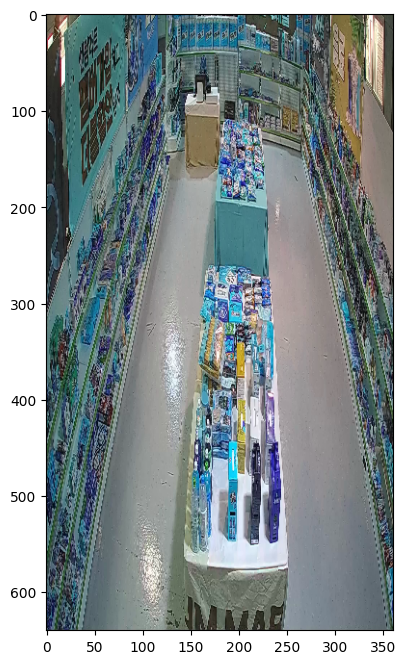

In [91]:
trainSample = trainSet[1400]
print(trainSample[0].shape)

plt.figure(figsize=(8,8))
plt.imshow(trainSample[0][:, 0, :, :].permute(1,2,0))
plt.show()

In [92]:
BATCH_SIZE = 10
train_loader = DataLoader(trainSet, batch_size = BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(valSet, batch_size = BATCH_SIZE, shuffle=False, drop_last=True )

In [93]:
for k, v in train_loader:
    print(k.shape, v.shape)
    break

torch.Size([10, 3, 180, 640, 360]) torch.Size([10])


In [94]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    
    best_val_score = 0
    best_model = None
    
    for epoch in range(1, 100+1):
        print(f'Proceeding... ({epoch}/100)')
        model.train()
        train_loss = []
        for videos, labels in tqdm(iter(train_loader)):
            videos = videos.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(videos)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val F1 : [{_val_score:.5f}]')
        
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_val_score < _val_score:
            best_val_score = _val_score
            best_model = model
    
    return best_model

def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, trues = [], []
    
    with torch.no_grad():
        for videos, labels in tqdm(iter(val_loader)):
            videos = videos.to(device)
            labels = labels.to(device)
            
            logit = model(videos)
            
            loss = criterion(logit, labels)
            
            val_loss.append(loss.item())
            
            preds += logit.argmax(1).detach().cpu().numpy().tolist()
            trues += labels.detach().cpu().numpy().tolist()
        
        _val_loss = np.mean(val_loss)
    
    _val_score = f1_score(trues, preds, average='macro')
    return _val_loss, _val_score

In [95]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=1):
        super(BaseModel, self).__init__()
        self.feature_extract = nn.Sequential(
            nn.Conv3d(3, 8, (1, 3, 3)),
            nn.ReLU(),
            nn.BatchNorm3d(8),
            nn.MaxPool3d(2),
            nn.Conv3d(8, 32, (1, 2, 2)),
            nn.ReLU(),
            nn.BatchNorm3d(32),
            nn.MaxPool3d(2),
            nn.Conv3d(32, 64, (1, 2, 2)),
            nn.ReLU(),
            nn.BatchNorm3d(64),
            nn.MaxPool3d(2),
            nn.Conv3d(64, 128, (1, 2, 2)),
            nn.ReLU(),
            nn.BatchNorm3d(128),
            nn.MaxPool3d((3, 7, 7)),
        )
        self.classifier = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        batch_size = x.size(0)
        x = self.feature_extract(x)
        x = x.view(batch_size, -1)
        x = self.classifier(x)
        return x

In [ ]:
summary(model, input_size=[10, 3, 180, 640, 360])

In [96]:
model = BaseModel()
multimodel = nn.DataParallel(model)
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8)

infer_model = train(multimodel, optimizer, train_loader, val_loader, scheduler, device)

Proceeding... (1/100)


  0%|          | 0/144 [00:11<?, ?it/s]


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/hds_lab/anaconda3/envs/won/lib/python3.9/site-packages/torch/nn/parallel/parallel_apply.py", line 96, in _worker
    output = module(*input, **kwargs)
  File "/home/hds_lab/anaconda3/envs/won/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/hds_lab/anaconda3/envs/won/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1750, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_853430/298561190.py", line 28, in forward
    x = self.classifier(x)
  File "/home/hds_lab/anaconda3/envs/won/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/hds_lab/anaconda3/envs/won/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1750, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/hds_lab/anaconda3/envs/won/lib/python3.9/site-packages/torch/nn/modules/linear.py", line 125, in forward
    return F.linear(input, self.weight, self.bias)
RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x59136 and 1024x1)
